Shape original: (692500, 12)
Shape muestra: (2000, 12)
Shape final del dataset: (2000, 8)
MAE promedio: 0.938 (±0.019)


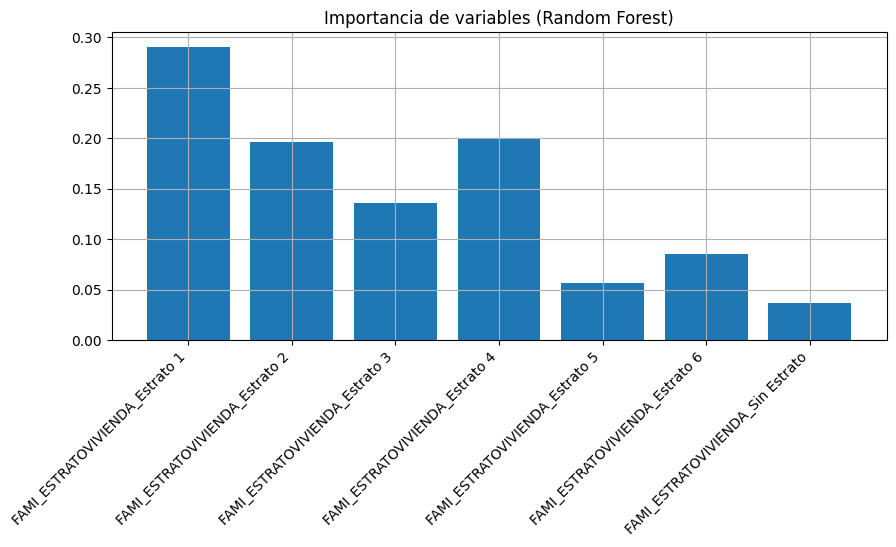

In [3]:
# 04 - MODELO CON PREPROCESADO IMPUTACION ESTRATO 2 Y RANDOM FOREST

# ---------------------------------------------------
# CARGA Y PREPROCESAMIENTO DE LOS DATOS
# ---------------------------------------------------

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score, ShuffleSplit
from sklearn.metrics import mean_absolute_error, make_scorer

# Cargamos el dataset completo
df = pd.read_csv("train.csv")
print("Shape original:", df.shape)

# Seleccionamos una muestra de 2000 registros para agilizar cómputo (igual que hicimos en el preprocesado)
df = df.sample(n=2000, random_state=42).reset_index(drop=True)
print("Shape muestra:", df.shape)

# Nos quedamos con las columnas relevantes (idéntico al preprocesado)
df = df[[
    'ID', 'PERIODO', 'FAMI_ESTRATOVIVIENDA', 'RENDIMIENTO_GLOBAL'
]]

# Eliminamos valores faltantes en 'RENDIMIENTO_GLOBAL'
df = df.dropna(subset=['RENDIMIENTO_GLOBAL'])

# ---------------------------------------------------
# IMPUTACIÓN ESTRATO: IMPUTAMOS ESTRATO 2 A LOS NULOS
# ---------------------------------------------------

col = "FAMI_ESTRATOVIVIENDA"
df[col] = df[col].fillna("Estrato 2")

# ---------------------------------------------------
# CODIFICACIÓN ONE-HOT PARA ESTRATO
# ---------------------------------------------------

def to_onehot(x):
    values = np.unique(x)
    r = np.r_[[np.argwhere(i==values)[0][0] for i in x]]
    return np.eye(len(values))[r].astype(int)

def replace_column_with_onehot(d, col):
    values = np.unique(d[col])
    k = to_onehot(d[col].values)
    r = pd.DataFrame(k, columns=["%s_%s" % (col, values[i]) for i in range(k.shape[1])], index=d.index).join(d)
    del r[col]
    return r

df_onehot = replace_column_with_onehot(df, col)

# ---------------------------------------------------
# TRANSFORMAMOS LA VARIABLE TARGET A NÚMERICA
# ---------------------------------------------------

rendimiento_map = {
    'bajo': 0,
    'medio-bajo': 1,
    'medio-alto': 2,
    'alto': 3
}
df_onehot['RENDIMIENTO_GLOBAL'] = df_onehot['RENDIMIENTO_GLOBAL'].map(rendimiento_map)

# ---------------------------------------------------
# ELIMINAMOS COLUMNAS NO INFORMATIVAS
# ---------------------------------------------------

# Eliminamos ID (identificador) y PERIODO (que no tiene significado directo para el rendimiento)
df_model = df_onehot.drop(columns=['ID', 'PERIODO'])

print("Shape final del dataset:", df_model.shape)

# ---------------------------------------------------
# ENTRENAMIENTO DEL RANDOM FOREST CON CROSS-VALIDATION
# ---------------------------------------------------

X = df_model.drop(columns=['RENDIMIENTO_GLOBAL']).values
y = df_model['RENDIMIENTO_GLOBAL'].values

estimator = RandomForestRegressor(n_estimators=100, random_state=42)
cv = ShuffleSplit(n_splits=30, test_size=0.3, random_state=42)

scores = cross_val_score(estimator, X, y, cv=cv, scoring=make_scorer(mean_absolute_error))

print("MAE promedio: %.3f (±%.3f)" % (scores.mean(), scores.std()))

# ---------------------------------------------------
# IMPORTANCIA DE VARIABLES
# ---------------------------------------------------

# Entrenamos el modelo final para visualizar importancia de variables
estimator.fit(X, y)

plt.figure(figsize=(10, 4))
plt.title("Importancia de variables (Random Forest)")
plt.bar(df_model.drop(columns=['RENDIMIENTO_GLOBAL']).columns, estimator.feature_importances_)
plt.xticks(rotation=45, ha="right")
plt.grid()
plt.show()
